# Error propagation: Example 3.6.2 in Sivia

## Problem to solve

This example illustrates a potential pitfall in a naive analysis of error propagation where we need to take a square root.
The context is the analysis of diffraction studies of crystalline materials.
The Bragg (or signal) peak is estimated using the signal-plus-background model considered earlier. 
Suppose this was done with a least-squares fitter (as opposed to a full Bayesian analysis) and a value $A = A_0 \pm \sigma_A$ is obtained.

This amplitude is related to the modulus squared of the complex structure factor (we'll say equal), so $A = |F|^2 = f^2$, with $f = |F|$. Our question is: what is the best estimate $f_0$ with error $\sigma_f$?

## Naive short cut for error propagation

It might seem that we can short cut a detailed treatment of error propagation simply by differentiating the relation between $A$ and $f$ at $f_0$, squaring and taking expectation values:

$$
 A = f^2 \ \Longrightarrow\ \delta A = 2 f_0 \delta f \ \Longrightarrow\
   \langle\delta A^2\rangle = 4 f_0^2 \langle \delta f^2 \rangle = 4 A_0 \langle \delta f^2 \rangle .
$$

Since $\langle\delta A^2\rangle = \sigma_A^2$, we can solve for $\sigma_f = \sqrt{\langle \delta f^2 \rangle}$ to get:

$$
   f \overset{?}{=} \sqrt{A_0} \pm \frac{\sigma_A}{2\sqrt{A_0}} .
$$

However, in the problem at hand, $A_0$ can be negative if there are weak and strongly overlapping reflections (or signal peaks). In this case the expression doesn't make sense.

There are two mistakes here:

&nbsp;&nbsp; 1. We have not distinguished between the likelihood, which is assumed to be a Gaussian distribution with mean (and maximum) $A_0$ and width $\sigma_A$, and the posterior. By Bayes' theorem the two are related by the likelihood being multiplied by a prior pdf (and a normalization, which we don't need to consider here). We have not accounted for the physics of $A$ in the latter, namely that it is never negative. So we need something like:

$$ p(A|I) = \begin{cases}
               1/A_{\text{max}} & 0 \leq A \leq A_{\text{max}} \\
               0 & \text{otherwise} 
            \end{cases}
$$ 

With a likelihood

$$
   p(D|A,I) \propto e^{-(A-A_0)^2/2\sigma_A^2}
$$

the best estimate for $A$ will be positive even if $A_0$ from fitting the data is negative.

&nbsp;&nbsp; 2. In the latter case, the posterior will be a truncated Gaussian that violates the implicit assumptions of the naive estimate, which is the second mistake. The estimate assumes we can expand around a central maximum, which won't be true in this case. 

## Doing it for real

So what do we do instead? Just apply the full expression for changing variables in pdfs:

$$\begin{align}
   p(f|D,I) &= p(A|D,I) \cdot \left|\frac{dA}{df}\right| = p(A|D,I) \cdot 2f \\
            &\propto f e^{-(f^2 - A_0)^2/2\sigma_A^2} \\
            &\approx \frac{1}{\sqrt{2\pi}\sigma_f}e^{-(f-f_0)^2/2\sigma_f^2}
\end{align}$$   

The third line is a Gaussian approximation to the full posterior for $f$ in the second line, found by Taylor expanding the logarithm $L = \log[p(f|D,I)]$ to second order in $f$ about $f_0$ (as we have done before). The first derivative is set to zero, identifying

$$ \left.\left[\frac{1}{f} + \frac{2A_0 f}{\sigma_A^2} - \frac{2f^3}{\sigma_A^2}\right]\right|_{f=f_0} = 0
\quad \Longrightarrow \quad 2 f_0^2 = A_0 + (A_0^2 + 2\sigma_A^2)^{1/2} ,$$

and the second derivative is minus one over the variance, identifying

$$ \frac{1}{\sigma_f^2} = \frac{1}{f_0^2} + \frac{2(3f_0^2 - A_0)}{\sigma_A^2} . $$

We can use as our estimate $f = f_0 \pm \sigma_f$ based on these formulas.

## Numerical illustrations

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from scipy import special

# Not really needed, but nicer plots
import seaborn as sns
sns.set()
sns.set_context("talk")

In [10]:
# Set up the functions to plot

# Posterior p(A|D,I)
def A_posterior(A, A0, sigA):
    pA = np.exp(-(A-A0)**2/(2*sigA**2))
    return pA/np.max(pA)

# Naive analysis (only works for A0>0)
def f_likelihood(f, A0, sigA):
    # likelihood p(D|f,I)
    sigf = sigA / (2*np.sqrt(A0))
    pf = np.exp(-(f-np.sqrt(A0))**2/(2*sigf**2))
    return pf/np.max(pf)

# Full posterior (with correct error propagation)
def f_posterior(f, A0, sigA):
    # p(f|D,I) normalized so one at the peak
    pf = f*np.exp(-(f**2-A0)**2/(2*sigA**2))
    return pf/np.max(pf)

# Approximate posterior
def f0(A0, sigA):
    # approximate peak of f_posterior
    return np.sqrt((A0 + np.sqrt(A0**2 + 2*sigA**2))/2)

def varf(A0, sigA):
    # approximate variance of f_posterior
    f0t = f0(A0,sigA)
    return 1/(1/f0t + 2*(3*f0t**2 - A0)/sigA**2)

def f_posterior_gaussian(f, A0, sigA):
    # gaussian approximation to full correct posterior
    pf = np.exp(-(f - f0(A0,sigA))**2/(2*varf(A0,sigA)))
    return pf/np.max(pf)

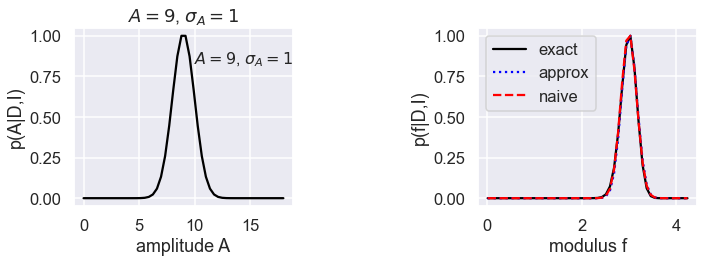

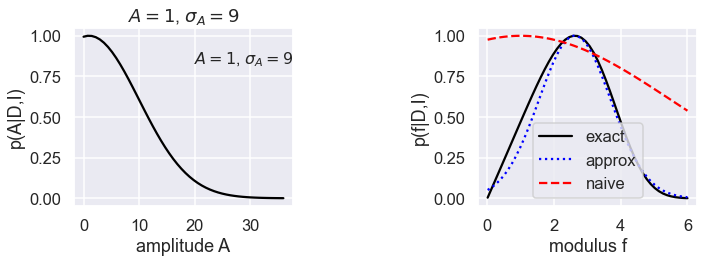

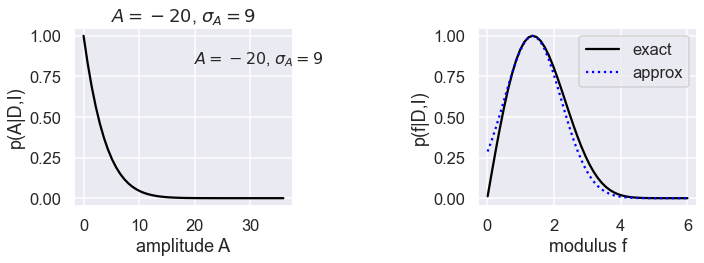

In [23]:
for (A0,sigA) in [(9,1),(1,9),(-20,9)]:
    maxA = max(2*A0,4*sigA)
    A_arr = np.linspace(0.001,maxA)
    f_arr = np.linspace(.01, np.sqrt(maxA))
    fig,ax = plt.subplots(1,2,figsize=(10,4))
    ax[0].plot(A_arr, A_posterior(A_arr,A0,sigA), color='black')
    ax[1].plot(f_arr, f_posterior(f_arr,A0,sigA), color='black', label='exact')
    ax[1].plot(f_arr, f_posterior_gaussian(f_arr,A0,sigA), linestyle='dotted', color='blue', label='approx')
    if A0>0:
        ax[1].plot(f_arr, f_likelihood(f_arr,A0,sigA), linestyle='dashed', color='red', label='naive')
    ax[0].set(xlabel='amplitude A',ylabel='p(A|D,I)')
    plt.text(0.55,0.8, f'$A={A0}$, $\sigma_A={sigA}$', transform=ax[0].transAxes,fontsize=16)
    ax[0].set_title(f'$A={A0}$, $\sigma_A={sigA}$')
    ax[1].set(xlabel='modulus f',ylabel='p(f|D,I)')
    ax[1].legend()
    plt.tight_layout()


## Comments

* The graphs show three cases, with the posterior for the amplitude $A$ on the left and the posterior for $f$ on the right in each case. The exact posterior for $f$ is a black solid line, the Gaussian approximation is a dotted blue line, and the naive approximation is a dashed red line.
* Case 1 is $A=9$, $\sigma_A = 1$, which is a "normal" peak. All of the posteriors for $f$ agree.
* Case 2 has $A=1$, $\sigma_A = 9$, so a broad Gaussian that is cut off at $A=0$. The Gaussian approximation to the $f$ posterior is good near the peak and gets worse for small $f$, while the naive approximation is terrible everywhere.
* Case 3 has $A=-20$, $\sigma_A=9$, so the naive approximation can't even apply! The Gaussian approximation is again very good near the peak then degrades slightly away from the peak.